In [417]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error,mean_absolute_error

In [418]:
df = pd.read_csv('**/Data/CO2.csv')
df.head()

,Year,CO2
0,1800,0.00568
1,1801,0.00561
2,1802,0.00555
3,1803,0.00548
4,1804,0.00542


In [419]:
df.shape

(215, 2)

In [420]:
df.describe()

,Year,CO2
count,215.000000,215.000000
mean,1907.000000,6.741970
std,62.209324,6.522437
min,1800.000000,0.001750
25%,1853.500000,0.041050
50%,1907.000000,6.390000
75%,1960.500000,11.500000
max,2014.000000,18.200000


In [421]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    215 non-null    int64  
 1   CO2     215 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 3.5 KB


In [422]:
df.isnull().sum()

Year    0
CO2     0
dtype: int64

Summary from the above inital analysis: The data set has 215 rows and 2 columns, 
Descriptive stat indicate that the years in which the co2 emissions are recordes ranges from 1800 to 2014. There are no null values in the dataset

In [423]:
df[df.CO2 == df.CO2.max()] # Max CO2 emission value

,Year,CO2
179,1979,18.2


<AxesSubplot:>

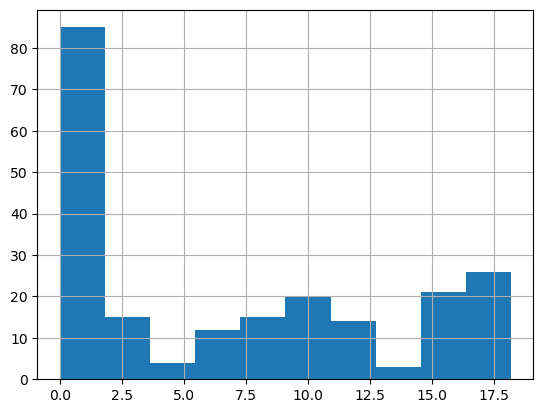

In [424]:
df['CO2'].hist()

The distribution for lower CO2 values dominates the higher CO2 emission values

In [425]:
df['CO2'].describe(percentiles = [0.25,0.50,0.75,0.85,0.90,1]) 

count    215.000000
mean       6.741970
std        6.522437
min        0.001750
25%        0.041050
50%        6.390000
75%       11.500000
85%       15.900000
90%       16.660000
100%      18.200000
max       18.200000
Name: CO2, dtype: float64

In [426]:
# convertion of 'year' to datetime format
df['Year'] = pd.to_datetime(df['Year'], format='%Y') 


In [427]:
df.set_index(['Year'],inplace = True)

<AxesSubplot:xlabel='Year'>

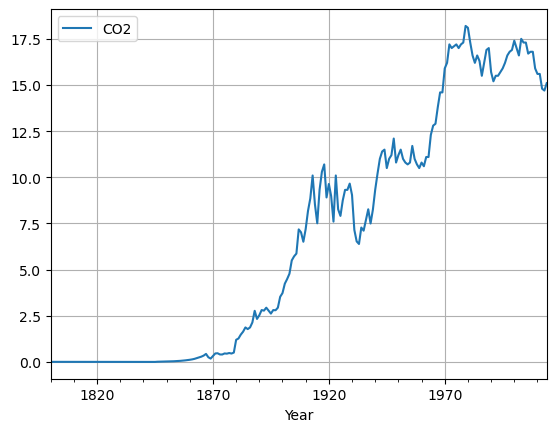

In [428]:
df.plot(grid=True)

As expected, as we progress through the years, the Co2 emissions get higher 
From the initial period until 1870, the data remains consistently low with minimal variance.
After 1870, thre is an increasing and decreasing trend. There could be various reasons for this like:

As countries undergo industrialization and experience economic growth, there is typically an increase in energy consumption, which often relies heavily on fossil fuels. The burning of fossil fuels releases CO2 into the atmosphere, leading to higher emissions.
The type of energy sources used for electricity generation and transportation plays a significant role in CO2 emissions.
The implementation of government policies and regulations targeting CO2 emissions can influence trends.
Increased awareness of climate change and the environmental impact of CO2 emissions has led to greater public engagement and individual efforts to reduce emissions

In [429]:
#Split Train and test set
train_df = df.loc[:'1991-01-01']
test_df= df.loc['1992-01-01':]

The seasonal_decompose function in time series analysis is used to decompose a time series into its underlying components: trend, seasonality, and residuals. It helps identify and understand the patterns and structures within the data.



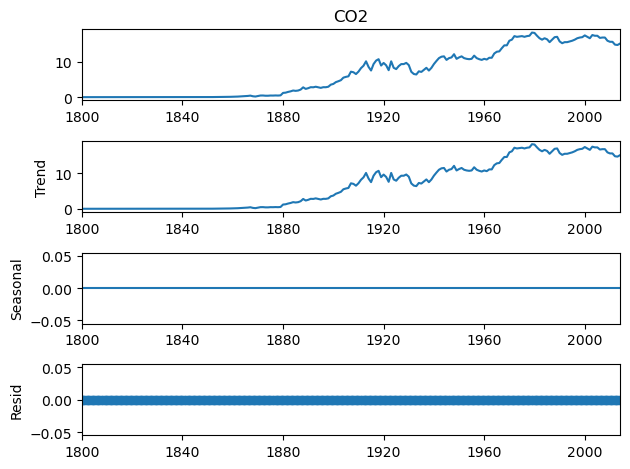

In [430]:
decompose = seasonal_decompose(df['CO2'])
decompose.plot();

Stationarity in time series refers to a property where the statistical properties of a time series, such as mean and variance, remain constant over time. It is essential because many time series analysis techniques assume stationarity for accurate modeling and forecasting. Non-stationary series can exhibit trends, seasonality, and changing statistical properties, making it difficult to extract meaningful insights or make reliable predictions.

Trend: The trend component represents the long-term, non-seasonal changes in the data. It captures the overall direction and tendency of the time series. It can be increasing, decreasing, or stationary.

Seasonality: The seasonality component captures repetitive patterns or cycles that occur within a fixed time period. It represents the regular and predictable fluctuations that happen at specific intervals, such as daily, weekly, monthly, or yearly patterns. Seasonality is often influenced by external factors like weather, holidays, or events.

Residuals (or Noise): The residuals component, also known as the remainder or noise, represents the unexplained variability or randomness in the data after removing the trend and seasonality. It contains the irregular fluctuations or unexpected changes that cannot be accounted for by the trend and seasonality components.



The Augmented Dickey-Fuller (ADF) test is a statistical test used to determine if a time series is stationary or exhibits unit root (non-stationarity). It tests the null hypothesis that a unit root is present in the series. By examining the test statistic and p-value, the ADF test helps determine if the series can be considered stationary or non-stationary.

In [431]:
def augdft(timeseries):
    print('Results of Augmented Dickey-Fuller Test:')
    print('----------------------------------------------')
    adftest = adfuller(timeseries)
    adf_output = {
        'Test Statistic': adftest[0],
        'p-value': adftest[1],
        '#Lags Used': adftest[2],
        'Number of Observations Used': adftest[3],
    }
    for key, value in adftest[4].items():
        adf_output[f'Critical Value ({key})'] = value
    print(pd.Series(adf_output))


In [432]:
augdft(df)

Results of Augmented Dickey-Fuller Test:
----------------------------------------------
Test Statistic                  -0.378463
p-value                          0.913633
#Lags Used                       0.000000
Number of Observations Used    214.000000
Critical Value (1%)             -3.461282
Critical Value (5%)             -2.875143
Critical Value (10%)            -2.574020
dtype: float64


The obtained p-value is greater than the significance level of 0.05, and the ADF statistic exceeds all critical values. Therefore, we conclude that the series is non-stationary.

Differencing in time series analysis is the process of computing the differences between consecutive observations to remove trends or seasonality. It is used to transform a non-stationary series into a stationary one, making it more amenable to analysis and modeling.

The parameter 'd' in the ARIMA model is determined by the number of differencing operations needed to achieve stationarity in the time series. The value of 'd' indicates the order of differencing and is an essential parameter in the ARIMA model for accurately modeling and forecasting the stationary time series.

In [433]:
#First order differencing for stationarity
df_diff = df.diff() 
df_diff.head()

,CO2
Year,
1800-01-01,NaN
1801-01-01,-0.00007
1802-01-01,-0.00006
1803-01-01,-0.00007
1804-01-01,-0.00006


In [434]:
df_diff.dropna(inplace = True)

<AxesSubplot:xlabel='Year'>

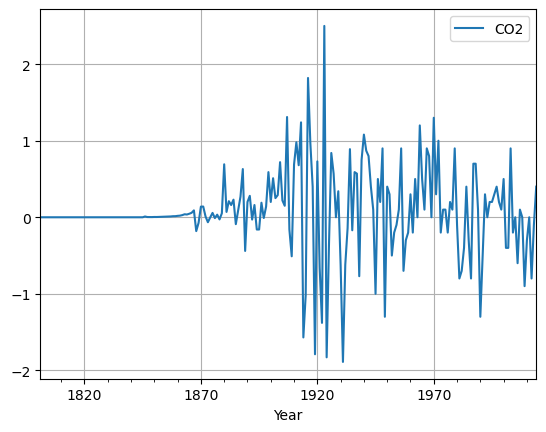

In [435]:
df_diff.plot(grid = True)


In [436]:
def augdft(timeseries):
    print('Results of Augmented Dickey-Fuller Test:')
    print('----------------------------------------------')
    adftest = adfuller(timeseries)
    adf_output = {
        'Test Statistic': adftest[0],
        'p-value': adftest[1],
        '#Lags Used': adftest[2],
        'Number of Observations Used': adftest[3],
    }
    for key, value in adftest[4].items():
        adf_output[f'Critical Value ({key})'] = value
    print(pd.Series(adf_output))


In [437]:
augdft(df_diff)

Results of Augmented Dickey-Fuller Test:
----------------------------------------------
Test Statistic                  -3.780005
p-value                          0.003119
#Lags Used                      15.000000
Number of Observations Used    198.000000
Critical Value (1%)             -3.463815
Critical Value (5%)             -2.876251
Critical Value (10%)            -2.574611
dtype: float64


After differencing, p value < 0.05 and the ADF statistic < critical values. Now, the first ordered differenced series is stationary and d=1

Autocorrelation Function (ACF): ACF measures the correlation between a time series and its lagged values at different time intervals. It helps identify the presence of any significant patterns or dependencies in the data.

"p" (AR order): It represents the number of lagged observations used in the autoregressive component. It indicates the number of past time steps that have a direct influence on the current value. Higher values of "p" indicate a longer memory or dependence on past values.

Partial Autocorrelation Function (PACF): PACF measures the correlation between a time series and its lagged values while removing the influence of intermediate lags. It helps identify the direct relationship between the current observation and a specific lag without the indirect effects of other lags.

"q" (MA order): It represents the number of lagged forecast errors used in the moving average component. It indicates the dependency on past forecast errors to predict the current value. Higher values of "q" indicate a greater emphasis on correcting past forecast errors.

Examine the tail of the pattern in either the ACF or PACF plot. If the tail crosses the significance threshold (blue region), it indicates potential values for p (autoregressive order) and q (moving average order) in time series modeling.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


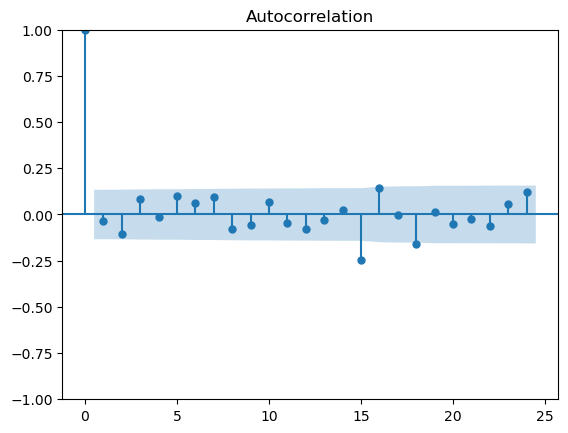

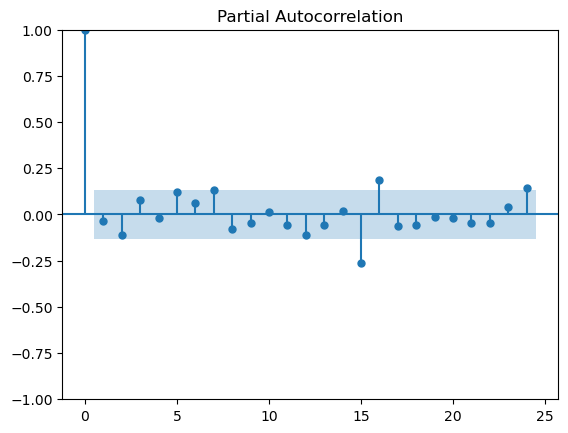

In [438]:
plot_acf(df_diff);
plot_pacf(df_diff);

From ACF plot, q values can be 15, 16 & 18
From PACF plot, p values can be 7,15,16 & 24

# TIME SERIES FORECASTING


# Single Exponential Smoothing

Single Exponential Smoothing is a time series forecasting method that uses a weighted average of past observations to predict future values. It assigns exponentially decreasing weights to older observations, with the most recent observations having a higher weight. This method is suitable for forecasting time series data with no trend or seasonality.

In [439]:
sexp = SimpleExpSmoothing(train_df).fit()
sexp_train_pred = sexp.fittedvalues
sexp_test_pred = sexp.forecast(23)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<AxesSubplot:xlabel='Year'>

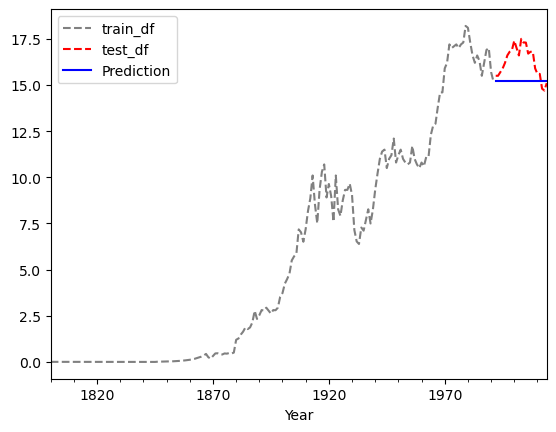

In [440]:
train_df['CO2'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['CO2'].plot(style='--', color='r', legend=True, label='test_df')
sexp_test_pred.plot(color='b', legend=True, label='Prediction')

In [441]:
print('Train RMSE:',mean_squared_error(train_df, sexp_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df, sexp_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df, sexp_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df,  sexp_test_pred))

Train RMSE: 0.5646920026800116
Test RMSE: 1.342911302270165
Train MAPE: 0.08470530767414804
Test MAPE: 0.06861466412077383


# Double Exponential Smoothing


Double Exponential Smoothing, also known as Holt's Exponential Smoothing, is a time series forecasting method that extends Single Exponential Smoothing by incorporating a trend component. It uses two sets of weights, one for the level (current value) and another for the trend (rate of change), to forecast future values, making it suitable for data with a consistent trend but no seasonality.

In [442]:
dexp = ExponentialSmoothing(train_df, trend=None, initialization_method='heuristic', seasonal='add', seasonal_periods=29, damped_trend=False).fit()
dexp_train_pred = dexp.fittedvalues
dexp_test_pred = dexp.forecast(23)


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


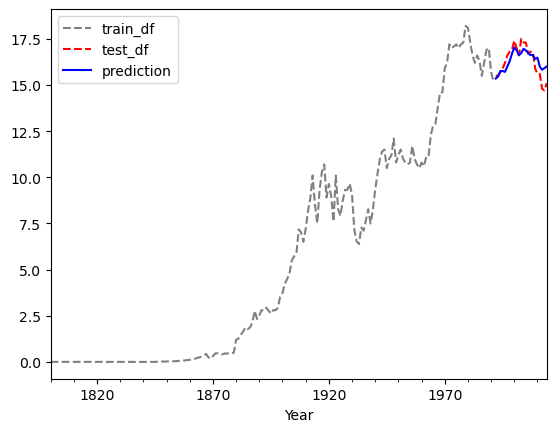

In [443]:
train_df['CO2'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['CO2'].plot(style='--', color='r', legend=True, label='test_df')
dexp_test_pred.plot(color='b', legend=True, label='prediction')
plt.show()


In [444]:
print('Train RMSE:',mean_squared_error(train_df, dexp_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df, dexp_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df, dexp_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df, dexp_test_pred))

Train RMSE: 0.5219963052653047
Test RMSE: 0.5352720574221986
Train MAPE: 12.80676949834386
Test MAPE: 0.026063825837478335


# Triple Exponential Smoothing

Triple Exponential Smoothing, also known as Holt-Winters Exponential Smoothing, is a time series forecasting method that extends Double Exponential Smoothing by incorporating a seasonality component in addition to the level and trend components. It is suitable for time series data that exhibit both trend and seasonality patterns. Triple Exponential Smoothing involves smoothing the level, trend, and seasonal components of the data to forecast future values.

In [445]:
tripexp = ExponentialSmoothing(train_df['CO2'],
                          trend    ='add',
                          initialization_method='heuristic',
                          seasonal = "add", 
                          seasonal_periods=28, 
                          damped_trend=True).fit()
tripexp_train_pred =  tripexp.fittedvalues
tripexp_test_pred =  tripexp.forecast(23)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


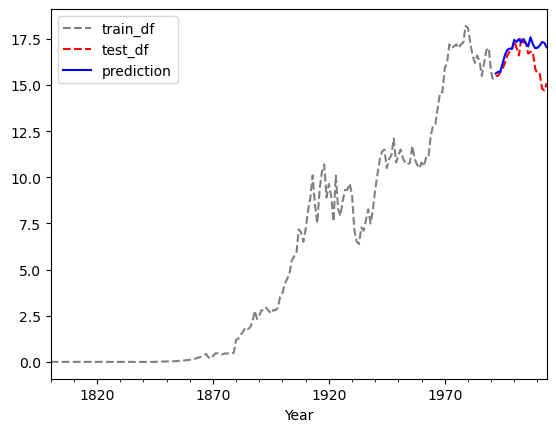

In [446]:
train_df['CO2'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['CO2'].plot(style='--', color='r', legend=True, label='test_df')
tripexp_test_pred.plot(color='b', legend=True, label='prediction')
plt.show()

In [447]:
print('Train RMSE:',mean_squared_error(train_df, tripexp_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df, tripexp_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df, tripexp_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df, tripexp_test_pred))

Train RMSE: 0.5106136819354261
Test RMSE: 1.0377035674553476
Train MAPE: 14.258480781249787
Test MAPE: 0.044712190954021055


# ARIMA 

ARIMA stands for Autoregressive Integrated Moving Average. It is a popular time series forecasting method that combines autoregressive (AR), moving average (MA), and differencing (I) components. ARIMA models are widely used for forecasting time series data with trends and seasonality.

The parameters p, q, and d represent the orders of the AR, MA, and differencing components, respectively:

p (AR order): It represents the number of lagged observations included in the model to capture the autoregressive component. It indicates the dependence of the current observation on its past values.

q (MA order): It represents the number of lagged forecast errors (residuals) included in the model to capture the moving average component. It indicates the dependence of the current observation on past forecast errors.

d (Differencing order): It represents the number of times the time series is differenced to achieve stationarity. Differencing removes trends and seasonality from the data, making it more suitable for ARIMA modeling. The differencing order captures the extent of differencing required to achieve stationarity.

In [448]:
arima = ARIMA(train_df, order=(15,1,15)).fit()
arima_train_pred = arima.fittedvalues
arima_test_pred = arima.forecast(23)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


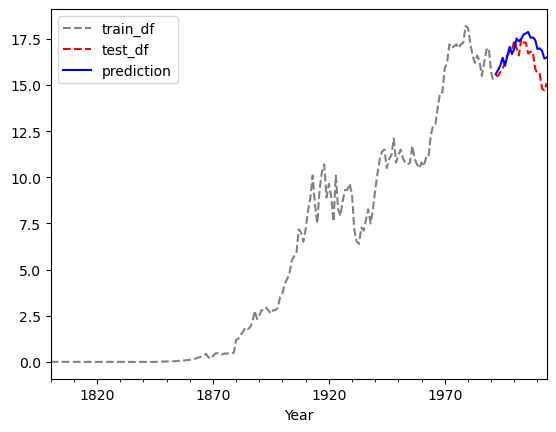

In [449]:
train_df['CO2'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['CO2'].plot(style='--', color='r', legend=True, label='test_df')
arima_test_pred.plot(color='b', legend=True, label='prediction')
plt.show()

In [450]:
print('Train RMSE:',mean_squared_error(train_df, arima_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df, arima_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df, arima_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df, arima_test_pred))

Train RMSE: 0.4679166965484632
Test RMSE: 0.9336108178286331
Train MAPE: 0.08147601684641907
Test MAPE: 0.04629785164005098


In [451]:
# evaluating ARIMA model for a provided order (p,d,q)
def arima_evaluation(arima_order):
    # prepare training dataset
    train_df = df.loc[:'1991-01-01']
    test_df = df.loc['1992-01-01':]
    
    # make predictions
    arimamodel = ARIMA(train_df, order=arima_order).fit()
    model_pred = arimamodel.forecast(23)
    rmse = (mean_squared_error(test_df, model_pred)**0.5)
    return rmse

In [452]:
# evaluating combinations of p, d and q values for the ARIMA model
def models_evaluation(dataset, p_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for q in q_values:
                order = (p,1,q)
                try:
                    rmse = arima_evaluation(order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                except:
                    continue
    print('Best ARIMA_MODEL%s RMSE=%.3f' % (best_cfg, best_score))


In [453]:
# evaluate parameters
p_values = [7,15,16,24]
q_values = [15,16,18]

models_evaluation(df['CO2'].values, p_values, q_values)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferre

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. U

Best ARIMA_MODEL(16, 1, 16) RMSE=0.845


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [454]:
arimamodel = ARIMA(train_df['CO2'], order=(16,1,16)).fit()
arimamodel_train_pred = arima.predict()
arimamodel_test_pred = arimamodel.forecast(23)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


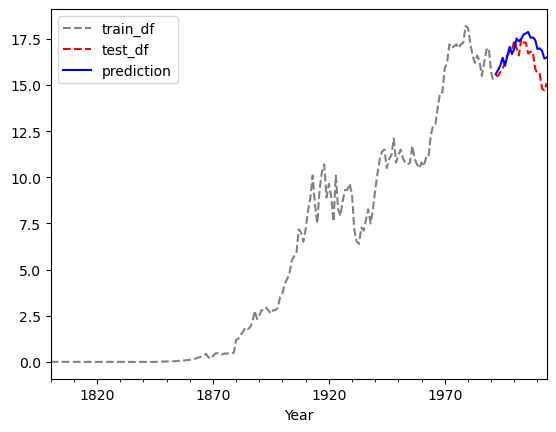

In [455]:
train_df['CO2'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['CO2'].plot(style='--', color='r', legend=True, label='test_df')
arima_test_pred.plot(color='b', legend=True, label='prediction')
plt.show()

In [456]:
print('Train RMSE:',mean_squared_error(train_df, arima_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df, arima_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df, arima_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df, arima_test_pred))

Train RMSE: 0.4679166965484632
Test RMSE: 0.9336108178286331
Train MAPE: 0.08147601684641907
Test MAPE: 0.04629785164005098


In [457]:
train_df.head()  

,CO2
Year,
1800-01-01,0.00568
1801-01-01,0.00561
1802-01-01,0.00555
1803-01-01,0.00548
1804-01-01,0.00542


# LSTM

LSTM (Long Short-Term Memory) is a type of recurrent neural network (RNN) architecture that can effectively process and predict patterns in sequential data by utilizing specialized memory units and gating mechanisms to capture long-term dependencies. It is commonly used for tasks like time series forecasting, natural language processing, and speech recognition.

In [458]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
 
# univariate data preparation
from numpy import array
 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps # find the end of this pattern 
        if end_ix > len(sequence)-1:  #check if we are beyond the sequence  
            break       
 # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [459]:
# define input sequence
raw_seq = df['CO2']
# choose a number of time steps
n_steps = 29
# split into samples
X, y = split_sequence(raw_seq, n_steps)

In [460]:
x_train_df, y_train_df = X[:-23], y[:-23]
x_test_df, y_test_df = X[-23:], y[-23:]

x_train_df.shape, y_train_df.shape, x_test_df.shape, y_test_df.shape


((163, 29), (163,), (23, 29), (23,))

In [461]:
lstm = Sequential()
lstm.add(InputLayer((29,1)))
lstm.add(LSTM(50))
lstm.add(Dense(10,'relu'))
lstm.add(Dense(5,'relu'))
lstm.add(Dense(1,'linear'))

lstm.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 50)                10400     
                                                                 
 dense_18 (Dense)            (None, 10)                510       
                                                                 
 dense_19 (Dense)            (None, 5)                 55        
                                                                 
 dense_20 (Dense)            (None, 1)                 6         
                                                                 
Total params: 10,971
Trainable params: 10,971
Non-trainable params: 0
_________________________________________________________________


2023-06-22 15:50:45.877752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-22 15:50:45.879064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-22 15:50:45.880616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [462]:
cp1 = ModelCheckpoint('lstm/', save_best_only=True)
lstm.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.1), metrics=[RootMeanSquaredError()])

In [463]:
lstm.fit(x_train_df, y_train_df, epochs=100, callbacks=[cp1])


Epoch 1/100


2023-06-22 15:50:46.288575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-22 15:50:46.289792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-22 15:50:46.291396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 2s 10ms/step - loss: 69.1868 - root_mean_squared_error: 8.3179
Epoch 2/100
6/6 [==============================] - 0s 15ms/step - loss: 36.5591 - root_mean_squared_error: 6.0464
Epoch 3/100
6/6 [==============================] - 0s 11ms/step - loss: 12.7432 - root_mean_squared_error: 3.5698
Epoch 4/100
6/6 [==============================] - 0s 12ms/step - loss: 5.4342 - root_mean_squared_error: 2.3311
Epoch 5/100
6/6 [==============================] - 0s 12ms/step - loss: 4.4223 - root_mean_squared_error: 2.1029
Epoch 6/100
6/6 [==============================] - 0s 11ms/step - loss: 4.0201 - root_mean_squared_error: 2.0050
Epoch 7/100
6/6 [==============================] - 0s 11ms/step - loss: 2.7679 - root_mean_squared_error: 1.6637
Epoch 8/100
6/6 [==============================] - 0s 11ms/step - loss: 1.6862 - root_mean_squared_error: 1.2985
Epoch 9/100
6/6 [==============================] - 0s 11ms/step - loss: 1.2008 - root_mean_squared_error:

6/6 [==============================] - 0s 9ms/step - loss: 1.1640 - root_mean_squared_error: 1.0789
Epoch 30/100
6/6 [==============================] - 0s 9ms/step - loss: 1.4453 - root_mean_squared_error: 1.2022
Epoch 31/100
6/6 [==============================] - 0s 9ms/step - loss: 2.0784 - root_mean_squared_error: 1.4417
Epoch 32/100
6/6 [==============================] - 0s 9ms/step - loss: 0.8040 - root_mean_squared_error: 0.8966
Epoch 33/100
6/6 [==============================] - 0s 9ms/step - loss: 1.1123 - root_mean_squared_error: 1.0547
Epoch 34/100
6/6 [==============================] - 0s 9ms/step - loss: 0.9160 - root_mean_squared_error: 0.9571
Epoch 35/100
6/6 [==============================] - 0s 9ms/step - loss: 1.1017 - root_mean_squared_error: 1.0496
Epoch 36/100
6/6 [==============================] - 0s 9ms/step - loss: 0.6378 - root_mean_squared_error: 0.7986
Epoch 37/100
6/6 [==============================] - 0s 9ms/step - loss: 0.8081 - root_mean_squared_error: 0.8

6/6 [==============================] - 0s 9ms/step - loss: 1.6507 - root_mean_squared_error: 1.2848
Epoch 59/100
6/6 [==============================] - 0s 9ms/step - loss: 0.7211 - root_mean_squared_error: 0.8492
Epoch 60/100
6/6 [==============================] - 0s 9ms/step - loss: 0.5415 - root_mean_squared_error: 0.7358
Epoch 61/100
6/6 [==============================] - 0s 9ms/step - loss: 0.7079 - root_mean_squared_error: 0.8414
Epoch 62/100
6/6 [==============================] - 0s 9ms/step - loss: 0.5084 - root_mean_squared_error: 0.7130
Epoch 63/100
6/6 [==============================] - 0s 9ms/step - loss: 0.5675 - root_mean_squared_error: 0.7534
Epoch 64/100
6/6 [==============================] - 0s 9ms/step - loss: 0.4506 - root_mean_squared_error: 0.6713
Epoch 65/100
6/6 [==============================] - 0s 9ms/step - loss: 0.7551 - root_mean_squared_error: 0.8689
Epoch 66/100
6/6 [==============================] - 0s 9ms/step - loss: 0.7596 - root_mean_squared_error: 0.8

6/6 [==============================] - 0s 9ms/step - loss: 0.5773 - root_mean_squared_error: 0.7598
Epoch 87/100
6/6 [==============================] - 0s 9ms/step - loss: 1.0359 - root_mean_squared_error: 1.0178
Epoch 88/100
6/6 [==============================] - 0s 9ms/step - loss: 2.2870 - root_mean_squared_error: 1.5123
Epoch 89/100
6/6 [==============================] - 0s 9ms/step - loss: 1.7224 - root_mean_squared_error: 1.3124
Epoch 90/100
6/6 [==============================] - 0s 9ms/step - loss: 0.9843 - root_mean_squared_error: 0.9921
Epoch 91/100
6/6 [==============================] - 0s 9ms/step - loss: 1.4431 - root_mean_squared_error: 1.2013
Epoch 92/100
6/6 [==============================] - 0s 9ms/step - loss: 0.7319 - root_mean_squared_error: 0.8555
Epoch 93/100
6/6 [==============================] - 0s 9ms/step - loss: 0.8548 - root_mean_squared_error: 0.9246
Epoch 94/100
6/6 [==============================] - 0s 9ms/step - loss: 0.9601 - root_mean_squared_error: 0.9

In [464]:
test_predictions = lstm.predict(x_test_df).flatten()
test_df['lstm_predictions'] = test_predictions

1/1 [==============================] - 0s 303ms/step


2023-06-22 15:50:54.430362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-22 15:50:54.431455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-22 15:50:54.432919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

<AxesSubplot:xlabel='Year'>

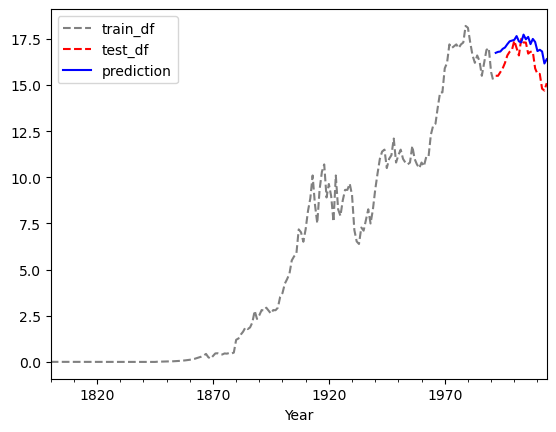

In [465]:
train_df['CO2'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['CO2'].plot(style='--', color='r', legend=True, label='test_df')
test_df['lstm_predictions'].plot(color='b', legend=True, label='prediction')

In [466]:
print('Test RMSE:',mean_squared_error(test_df['CO2'], test_df['lstm_predictions'])**0.5)
print('Test MAPE:',mean_absolute_percentage_error(test_df['CO2'], test_df['lstm_predictions']))

Test RMSE: 1.002956872405047
Test MAPE: 0.05568269465195061


# Which model perfomed better?

In [467]:
models_comp = pd.DataFrame(data=[['Single exp smoothing', 1.3429 , 0.0686],
                           ['double exp smoothing', 0.5352,  0.0260],
                          ['Triple exp smoothing', 1.0377, 0.0447],
                          ['ARIMA(16,1,16)', 0.9336, 0.0462],
                          ['LSTM', 0.5441, 0.0270]], columns=['Model','RMSE','MAPE'])

models_comp.set_index('Model', inplace=True)

In [468]:
models_comp.sort_values(by='RMSE')


,RMSE,MAPE
Model,,
double exp smoothing,0.5352,0.0260
LSTM,0.5441,0.0270
"ARIMA(16,1,16)",0.9336,0.0462
Triple exp smoothing,1.0377,0.0447
Single exp smoothing,1.3429,0.0686


The Double Exponential Smoothing and LSTM models showed similar performance. With slight adjustments to the hyperparameters, LSTM could potentially outperform Double Exponential Smoothing. However, based on the results obtained, the Double Exponential Smoothing model performed the best, so the entire training data is trained using this model.

In [469]:
dexp = ExponentialSmoothing(df, trend=None, initialization_method='heuristic', seasonal='add', seasonal_periods=29, damped_trend=False).fit()
dexp_pred = dexp.forecast(20)


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


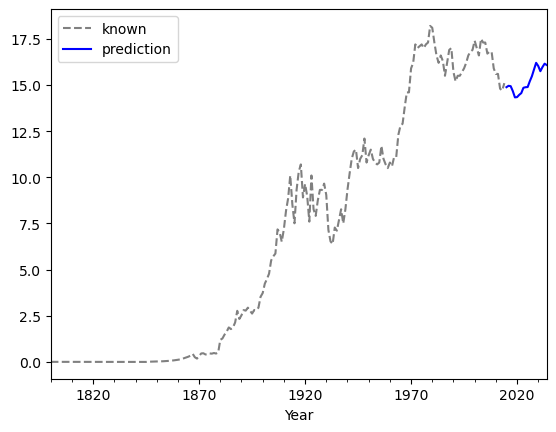

In [470]:
df['CO2'].plot(style='--', color='gray', legend=True, label='known')
dexp_pred.plot(color='b', legend=True, label='prediction')
plt.show()

In [472]:
file = open("CO2_forecast_Model.pkl", "wb") # opening a new file in write mode
pickle.dump(dexp, file) # dumping created model into a pickle file
file.close()

In [474]:
!pip install -q streamlit

In [475]:
!npm install -g localtunnel -U

m##################) ⠦ reify:yargs: timing reifyNode:node_modules/localtunnel/nocaltu[K[K
changed 22 packages in 2s

3 packages are looking for funding
  run `npm fund` for details


In [477]:
%%writefile CO2_forecasting_app.py 

# importing necessary libraries
import pickle
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings("ignore")



#load the model
model = pickle.load(open('/**/EcoTrendPredictor/CO2_forecast_Model.pkl','rb'))

#load dataset to plot alongside predictions
df = pd.read_csv("/**/EcoTrendPredictor/Data/CO2.csv")
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df.set_index(['Year'], inplace=True)


#page configuration
st.set_page_config(layout='centered') #configures the page layout to be centered
image = Image.open('/**co2.jpg')
st.image(image) # displays the image on the Streamlit application

year = st.slider("Select number of Years",1,30,step = 1) #creates a slider widget where the user can select a 
                                                        #number of years between 1 and 30.
    
    
pred = model.forecast(year) #predict future values based on the selected number of years.
pred = pd.DataFrame(pred, columns=['CO2'])  # predicted values are stored in pred.
   
if st.button("Predict"):

        col1, col2 = st.columns([2,3])
        with col1:
             st.dataframe(pred)
        with col2:
            fig, ax = plt.subplots(figsize=(10, 12))
            df['CO2'].plot(style='--', color='gray', legend=True, label='known')
            pred['CO2'].plot(color='b', legend=True, label='prediction')
            
            # Increase font size
            plt.xlabel('X-axis label', fontsize=12)
            plt.ylabel('Y-axis label', fontsize=12)
            plt.xticks(fontsize=12)
            plt.yticks(fontsize=12)
            plt.legend(fontsize=12)
            st.pyplot(fig)

Overwriting CO2_forecasting_app.py


In [ ]:
!streamlit run co2_forecasting_app.py & npx localtunnel --port 8501 

your url is: https://solid-points-jog.loca.lt

  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://192.168.0.13:8501

